In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# Load Signals and Original Price Data 
signals_df = spark.table("tesla_model_signals").toPandas()
price_df = spark.table("tsla").select("Date", "Close").toPandas()

In [0]:
price_df.describe()

,Date,Close
count,3534,3534
unique,3534,3334
top,2010-06-29,1.8279999494552612
freq,1,4


In [0]:
price_df['Date'] = pd.to_datetime(price_df['Date'])
signals_df['Date'] = pd.to_datetime(signals_df['Date'])

In [0]:
# Merge on Date column
signals_df = signals_df.merge(price_df, on='Date', how='left')
signals_df = signals_df.sort_values('Date').reset_index(drop=True)

In [0]:
# When model signal = 1, we assume a long position for next day

# Convert Close to numeric
signals_df['Close'] = pd.to_numeric(signals_df['Close'], errors='coerce')

# Calculate daily returns
signals_df['Daily_Return'] = signals_df['Close'].pct_change()
signals_df['Strategy_Return'] = signals_df['Signal'].shift(1) * signals_df['Daily_Return']

In [0]:
# Cumulative Returns
signals_df['Cumulative_Market'] = (1 + signals_df['Daily_Return']).cumprod()
signals_df['Cumulative_Strategy'] = (1 + signals_df['Strategy_Return']).cumprod()

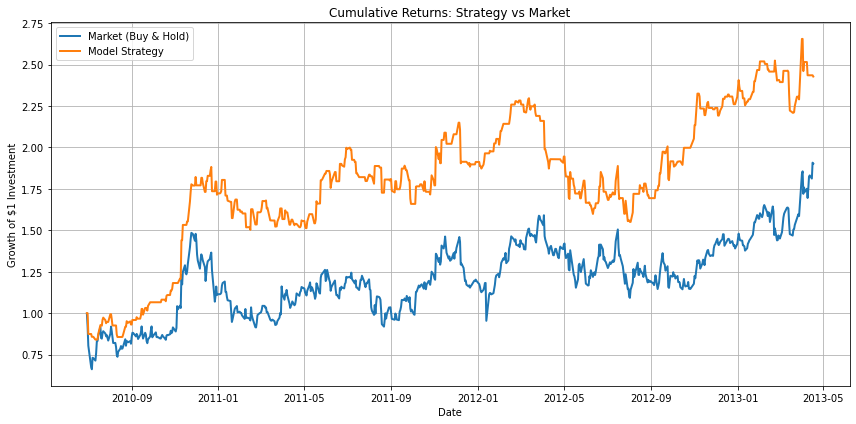

In [0]:
# Plotting Strategy vs Market Performance
plt.figure(figsize=(12, 6))
plt.plot(signals_df['Date'], signals_df['Cumulative_Market'], label='Market (Buy & Hold)', linewidth=2)
plt.plot(signals_df['Date'], signals_df['Cumulative_Strategy'], label='Model Strategy', linewidth=2)
plt.title('Cumulative Returns: Strategy vs Market')
plt.xlabel('Date')
plt.ylabel('Growth of $1 Investment')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [0]:
final_market_return = signals_df['Cumulative_Market'].iloc[-1] - 1
final_strategy_return = signals_df['Cumulative_Strategy'].iloc[-1] - 1

print(f"📈 Final Market Return: {final_market_return:.2%}")
print(f"📊 Final Strategy Return: {final_strategy_return:.2%}")

📈 Final Market Return: 90.25%
📊 Final Strategy Return: 142.83%


In [0]:
backtest_spark_df = spark.createDataFrame(signals_df)

# Save as a managed table in Databricks (overwrite if exists)
backtest_spark_df.write.mode('overwrite').saveAsTable('tesla_backtest_results')

In [0]:
spark.sql("SHOW TABLES").show()

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
| default|tesla_backtest_re...|      false|
| default| tesla_model_signals|      false|
| default|tesla_stock_features|      false|
| default|                tsla|      false|
+--------+--------------------+-----------+

